In [20]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addAtomIndices=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


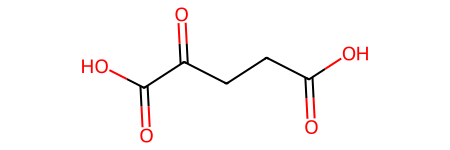

In [3]:
# Test mol

smi = "O=C(O)CCC(=O)C(=O)O"
mol = Chem.MolFromSmiles(smi)
mol

In [6]:
%load_ext autoreload
%autoreload 2

import torch
from chemprop.data import build_dataloader
from chemprop import models
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_known_rxns
from src.utils import construct_sparse_adj_mat
from src import data
from src.featurizer import RCVNReactionMolGraphFeaturizer, MultiHotAtomFeaturizer, MultiHotBondFeaturizer
from sklearn.model_selection import train_test_split
import numpy as np
from lightning import pytorch as pl
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

df = pd.read_csv("./artifacts/model_evals/gnn/rc_gnn_v0_sprhea_sp_folded_pt_rxns_x_min_ops_100_epochs_seed_1234/version_1/metrics.csv")
df.head()

,batch_averaged_test/ce,epoch,step,train_loss
0,NaN,0,49,1734.673584
1,NaN,1,99,1109.704834
2,NaN,1,149,814.335144
3,NaN,2,199,647.530273
4,NaN,2,249,455.589600


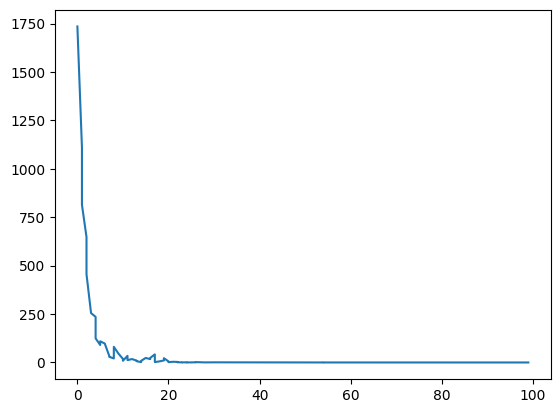

In [3]:
plt.plot(df.loc[:,"epoch"], df.loc[:,"train_loss"])
plt.show()

In [4]:
# Load trained model
path = "./artifacts/model_evals/gnn/rc_gnn_v0_sprhea_sp_folded_pt_rxns_x_min_ops_100_epochs_seed_1234/version_1/checkpoints/epoch=99-step=8400.ckpt"
mpnn = models.MPNN.load_from_file(path, map_location=torch.device('cpu'))

dataset = 'sprhea'
toc = 'sp_folded_pt_rxns_x_min_ops'
krs = load_known_rxns("./data/sprhea/known_rxns_240310_v2_folded_protein_transcript.json")
seed = 1234

# Load data
adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset, toc)
feature_idx = {v:k for k,v in idx_feature.items()}
X = [krs[k] for k in list(krs.keys())]
min_rule_labels = ["_".join(sorted(elt['min_rules'])) for elt in X] # Rule names
min_rule_idxs = np.array([feature_idx[elt] for elt in min_rule_labels]) # Indices in adj mat
n_samples = len(X)
n_classes = len(feature_idx)
y = min_rule_idxs.reshape(-1,1) # Class index encoding

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

# Init featurizer
featurizer = RCVNReactionMolGraphFeaturizer(
    atom_featurizer=MultiHotAtomFeaturizer.no_stereo(),
    bond_featurizer=MultiHotBondFeaturizer()
)

# Construct dataset
datapoints_train = [data.RxnRCDatapoint.from_smi(kr, y=y_train[i]) for i, kr in enumerate(X_train)]
datapoints_test = [data.RxnRCDatapoint.from_smi(kr, y=y_test[i]) for i, kr in enumerate(X_test)]

dataset_train = data.RxnRCDataset(datapoints_train, featurizer=featurizer)
dataset_test = data.RxnRCDataset(datapoints_test, featurizer=featurizer)

data_loader_train = build_dataloader(dataset_train, shuffle=False)
data_loader_test = build_dataloader(dataset_test, shuffle=False)


Constructing sprhea:sp_folded_pt_rxns_x_min_ops sparse adjacency matrix


In [5]:
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="cpu",
        devices=1
    )
    test_preds = trainer.predict(mpnn, data_loader_test)

/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/spn1560/.conda/envs/hiec/lib/python3.11/site-p ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
test_preds = np.concatenate(test_preds, axis=0).reshape(-1, n_classes)
y_pred = np.argmax(test_preds, axis=1).reshape(-1,)
y_true = dataset_test.Y.reshape(-1,)

In [18]:

scorers = {
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'),
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro'),
    'accuracy': accuracy_score
}

scores = {}

for k, scorer in scorers.items():
    scores[k] = scorer(y_true, y_pred)

print(scores)

{'f1': 0.6851028424140526, 'precision': 0.6763747507593376, 'recall': 0.7130462987664987, 'accuracy': 0.9470124013528749}


/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
